**0. Data preparation**

In [ ]:
pip install pyblp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pyblp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

pyblp.options.digits = 2
pyblp.options.verbose = False

In [58]:
data=pd.read_excel('/content/data_HA.xlsx')
data.head()

/usr/local/lib/python3.8/dist-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,prices,shares,market_ids,firm_ids,quality,satellite,wired,demand_instruments0
0,2.636681,0.469490,0,0,0.921656,1,0,0.072425
1,2.812415,0.237731,0,1,1.834763,1,0,0.548527
2,2.417776,0.038745,0,2,0.762334,0,1,0.868230
3,2.321038,0.163560,0,3,1.399432,0,1,0.135893
4,2.534516,0.114659,1,0,0.082587,1,0,0.235976


**3.1 Data Comprehension**

a. Compute the share of consumers not buying any of the 4 goods in market 1.


In [22]:
indicator=data['market_ids']==0
market0=data[indicator]
inside=market0['shares'].sum()
outside=1 - inside
round(outside,4)

0.0905

b.  For market 1, compute the market share of good 1 within the group of all satellite services goods.

In [23]:
indicator2=data['firm_ids']==0
good1=data[indicator & indicator2]
s_good1=good1["shares"].sum()
indicator3=data['satellite']==1
s_s=s_good1/data[indicator & indicator3]['shares'].sum()
round(s_s, 4)

0.6639

c. For market 1, compute the average price of satellite services and the average price of wired services.

In [18]:
av_price_s=data[indicator & indicator3]['prices'].mean()
av_price_w=data[indicator & -indicator3]['prices'].mean()
# average price of satellite services = 2.7245
# average price of wired services = 2.3694

**3.2 Plain Logit and OLS**

a. Estimate the plain logit model using the instrumental variable for price provided in the dataset. (Report all beta and alpha estimates.) Which service provides on average more utility at the baseline (zero) level of quality — satellite or wired? (Just compare point estimates.)

In [19]:
logit_formulation=pyblp.Formulation('0 + quality + satellite + wired + prices')

problem=pyblp.Problem(logit_formulation, data)
problem

Dimensions:
 T     N     F    K1    MD 
----  ----  ---  ----  ----
1000  4000   4    4     4  

Formulations:
     Column Indices:           0         1        2      3   
--------------------------  -------  ---------  -----  ------
X1: Linear Characteristics  quality  satellite  wired  prices

In [25]:
logit_results=problem.solve()
logit_results

Problem Results Summary:
GMM   Objective  Clipped  Weighting Matrix  Covariance Matrix
Step    Value    Shares   Condition Number  Condition Number 
----  ---------  -------  ----------------  -----------------
 2    +2.8E-25      0         +2.3E+01          +1.7E+03     

Cumulative Statistics:
Computation   Objective 
   Time      Evaluations
-----------  -----------
 00:00:00         2     

Beta Estimates (Robust SEs in Parentheses):
 quality    satellite     wired       prices  
----------  ----------  ----------  ----------
 +9.4E-01    +4.1E+00    +3.0E+00    -2.0E+00 
(+2.5E-02)  (+1.5E-01)  (+1.5E-01)  (+5.6E-02)

beta and alpha estimates (while all estimates are significant):

$\beta_{quality} = 0.94 \\
\beta_{satellite} = 4.1 \\
\beta_{wired} = 3.0 \\
\alpha = -2.0$

Satellite provides on average more utility at the baseline level of quality *(4.1 > 3.0)*.

b. Estimate the same model by OLS (recall that for this, one has to make the price its own instrument). Explain qualitatively why the bias in OLS has the sign it has.

In [26]:
#naively trying OLS without instruments, making price its own instrument
#deleting current instruments
data_OLS=data.drop(data.columns[7:], axis=1)
#adding a new instrument which is just price itself
data_OLS["demand_instruments0"]=data_OLS["prices"]
#creating an OLS estimation problem
problem_OLS = pyblp.Problem(logit_formulation, data_OLS)
logit_results_OLS = problem_OLS.solve()
logit_results_OLS

Problem Results Summary:
GMM   Objective  Clipped  Weighting Matrix  Covariance Matrix
Step    Value    Shares   Condition Number  Condition Number 
----  ---------  -------  ----------------  -----------------
 2    +1.5E-23      0         +6.4E+02          +1.2E+03     

Cumulative Statistics:
Computation   Objective 
   Time      Evaluations
-----------  -----------
 00:00:00         2     

Beta Estimates (Robust SEs in Parentheses):
 quality    satellite     wired       prices  
----------  ----------  ----------  ----------
 +8.5E-01    +1.7E+00    +7.5E-01    -1.1E+00 
(+2.3E-02)  (+1.2E-01)  (+1.1E-01)  (+4.4E-02)

The OLS price coefficient -1.1 is, as expected, less negative then the IV price coefficient -2. 

Hence, the endogeneity of price such that the price and  $\xi$  (unobservable quality components) are positively correlated.

c. Compute and visualize the matrix of elasticities for market 1 as we did in class. Report a numerical value of the elasticity of the share of good 2 with respect to price of good 4 in market 1. Describe in words what this elasticity means.

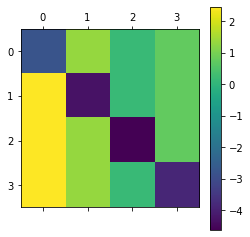

In [27]:
#computing elasticities
elasticities = logit_results.compute_elasticities()
#computing matrix of elasticities in a single market
single_market = data['market_ids'] == 0
#elasticities[single_market]
plt.colorbar(plt.matshow(elasticities[single_market]))

In [28]:
els_2_4 = elasticities[1][3]
els_2_4

0.7548040802957188

In the matrix above, element $(i,j)$ is the elasticity of market share of good $i$ with respect to price of good $j$. In order to indicate the numerical value of the elasticity of the share of good 2 at the price of good 4 in market 1, we need to take the element $(2,4)$: $\varepsilon^{p_4}_{s_2} = 0.755$

In Plain Logit, the cross-elasticity of $s_{i}$ with respect to  $p_j$  $(i\neq j)$ at a particular point does not depend on $i$. An increase in the price of good 4 *equally affects* the increase in demand for all other goods (as can be seen from the column shaded in one color in the elasticity matrix). 

If the price of good 4 increases by 1%, the market share of good 2 will increase by 0.75% (the same will happen with the shares of other goods 1 and 3).

d. Suppose consumer Alice buying from market 1 has the individual shocks $\varepsilon_{i1} = −1$, $\varepsilon_{i2} = 0$, $\varepsilon_{i3} = 1.5$, $\varepsilon_{i4} = −2$ and $\varepsilon_{i0} = 0.8$. Which good (out of 4 inside goods and the outside good) does she choose? *Hint: pyblp results.delta command might be of use here.*

In [29]:
delta_1 = logit_results.compute_delta(market_id = 0)
epsilion_i1 = -1
epsilion_i2 = 0
epsilion_i3 = 1.5
epsilion_i4 = -2
epsilion_i0 = 0.8

u_i1 = delta_1[0][0] + epsilion_i1
u_i2 = delta_1[1][0] + epsilion_i2
u_i3 = delta_1[2][0] + epsilion_i3
u_i4 = delta_1[3][0] + epsilion_i4
u_i0 = epsilion_i0

u_ij = [u_i1, u_i2, u_i3, u_i4, u_i0]
u_ij

[0.6465887141277653,
 0.9660798020291292,
 0.6519450831808693,
 -1.4078795193130436,
 0.8]

In [30]:
max(u_ij)

0.9660798020291292

Conclusion: 
Alice choose good with maximum utility (0.966) - good 2.

e. Suppose you work at a satellite provider $SS$ who has not entered market 1 yet but considers doing so. Your boss has tasked you with predicting what will be the market share of SS in the short run if it enters the market. $SS$ wants to set quality $x_{SS}$ equal to the current average quality of satellite services in the market and price $p_{SS}$ equal to the current average price of satellite services in the market. The $\xi$ shock for this new good is 0. In the short run, prices of existing products cannot change due to menu costs. Using your estimates, do what your boss wants of you.



Calculate the share of a new product using the formula, knowing all $\delta_{j0}$ on the market.


$\delta_{ss} = quality_{ss} \cdot \widehat{\beta_{quality}} + satellite_{ss} \cdot \widehat{\beta_{satellite}} + wired_{ss} \cdot \widehat{\beta_{wired}} + prices_{ss} \cdot \widehat{\beta_{prices}}$):

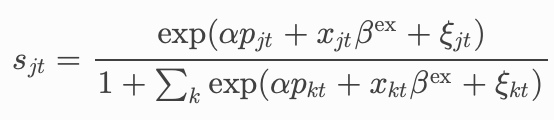

In [31]:
data_1 = data.loc[data['market_ids'] == 0]
dats_ss = data_1.groupby('satellite').mean()[['prices', 'quality']]
# average price of satellite services = 2.724548
# average quality of satellite services = 1.378210

delta_ss = dats_ss.iat[1,1]*0.94 + 4.1*1 + 3*0 - 2*dats_ss.iat[1,0]

s_ss = math.exp(delta_ss)/(math.exp(delta_ss) + math.exp(delta_1[0][0]) + math.exp(delta_1[1][0]) + math.exp(delta_1[2][0]) + math.exp(delta_1[3][0]) + math.exp(0))
s_ss

s_out = math.exp(0)/(math.exp(delta_ss) + math.exp(delta_1[0][0]) + math.exp(delta_1[1][0]) + math.exp(delta_1[2][0]) + math.exp(delta_1[3][0]) + math.exp(0))
s_1 = math.exp(delta_1[0][0])/(math.exp(delta_ss) + math.exp(delta_1[0][0]) + math.exp(delta_1[1][0]) + math.exp(delta_1[2][0]) + math.exp(delta_1[3][0]) + math.exp(0))
s_2 = math.exp(delta_1[1][0])/(math.exp(delta_ss) + math.exp(delta_1[0][0]) + math.exp(delta_1[1][0]) + math.exp(delta_1[2][0]) + math.exp(delta_1[3][0]) + math.exp(0))
s_3 = math.exp(delta_1[2][0])/(math.exp(delta_ss) + math.exp(delta_1[0][0]) + math.exp(delta_1[1][0]) + math.exp(delta_1[2][0]) + math.exp(delta_1[3][0]) + math.exp(0))
s_4 = math.exp(delta_1[3][0])/(math.exp(delta_ss) + math.exp(delta_1[0][0]) + math.exp(delta_1[1][0]) + math.exp(delta_1[2][0]) + math.exp(delta_1[3][0]) + math.exp(0))
share1 = [s_ss, s_1, s_2, s_3, s_4, s_out]
share1

[0.07898086388903966,
 0.4324096662385957,
 0.21895462756208028,
 0.03568497776820293,
 0.15064185628471471,
 0.08332800825736683]

The share of the new product will be equal to 0.079, but at the same time, other products with satellite services in market 1 have a much larger share, so a new product should not enter this market with these parameters.

**3.3 Nested Logit**

a. For the nested logit, we have a new parameter to estimate ($\lambda$ or $\rho$) and thus need one more instrument. A popular choice for this instrument is the number of goods in a good’s nest. Explain why we cannot use this instrument in this case.

In this case, the number of goods inside each nest is 2. It can be mentioned the quantity of satellite and wired goods is equal. This means there is always the same amount of observations in one nest.

b.
 Instead we will take the quality of the other good in the same nest as our instrument. Construct this instrument and name it *'demand_instruments1'*. 
 
 & 
 
 c.  Estimate the nested logit model. What does your estimate of $\rho (\lambda)$ says about the correlation of individual shocks among same-nest goods? Does there exist a strong nesting-by-type-of-service structure in our data?

In [47]:
def solve_nl(data):
  #nesting_ids is the identity of nest
    groups = data.groupby(['market_ids', 'nesting_ids'])
    #creating a new instrument: quality of the other good in the same nest
    data['demand_instruments1'] = groups['quality'].transform(lambda x: x.sum() - x)
    nl_formulation = pyblp.Formulation('0 + quality + satellite + wired + prices')
    problem = pyblp.Problem(nl_formulation, data)

    return problem.solve(rho=0.7)

In [48]:
data_nest = data.copy()
data_nest['nesting_ids'] = data_nest['satellite']
nl_results = solve_nl(data_nest)
nl_results

Problem Results Summary:
GMM   Objective    Projected    Reduced   Clipped  Weighting Matrix  Covariance Matrix
Step    Value    Gradient Norm  Hessian   Shares   Condition Number  Condition Number 
----  ---------  -------------  --------  -------  ----------------  -----------------
 2    +1.1E-24     +4.4E-11     +5.6E+02     0         +3.9E+01          +3.1E+03     

Cumulative Statistics:
Computation  Optimizer  Optimization   Objective 
   Time      Converged   Iterations   Evaluations
-----------  ---------  ------------  -----------
 00:00:21       Yes          2             6     

Rho Estimates (Robust SEs in Parentheses):
All Groups
----------
 +8.8E-02 
(+6.0E-02)

Beta Estimates (Robust SEs in Parentheses):
 quality    satellite     wired       prices  
----------  ----------  ----------  ----------
 +9.0E-01    +3.9E+00    +2.9E+00    -1.9E+00 
(+3.7E-02)  (+1.9E-01)  (+1.7E-01)  (+8.8E-02)

$\hat{\rho} = 0.088$

 Within the sets the correlation coefficient for the $\varepsilon_{ij}$ is approximately 0.088 (very weak, close to zero), therefore, this model is close to plain logit model. Due to the weak correlation in our data, there is no strong nesting-by-type-of-service structure.

$\lambda$ measures independence of individual shocks across goods inside nests and in this case is in the interval between 0 and 1 so the following conclusion can be made: the structure of nests is not so bad. Furthermore, the value of $\lambda$ shows that individual taste shocks have not significant correlation across goods in nests.

d.
 Compute the matrix of elasticities for market 1. Report a numerical value of the elasticity of the share of good 2 with respect to price of good 4 in market 1 and compare it with what you found in the plain logit case. Comment.

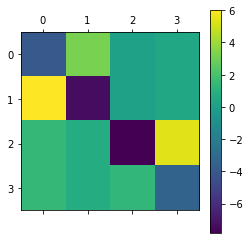

In [43]:
elasticities_nl = nl_results.compute_elasticities()
plt.colorbar(plt.matshow(elasticities_nl[indicator]))

In [45]:
els_2_4_nl = elasticities_nl[1][3]
els_2_4_nl

0.43093215441208615

In the matrix above, element $(i,j)$ is the elasticity of market share of good $i$ with respect to price of good $j$. In order to indicate the numerical value of the elasticity of the share of good 2 at the price of good 4 in market 1, we need to take the element $(2,4)$: $\varepsilon^{p_4}_{s_2} = 0.714$

If the price of good 4 increases by 1%, the market share of good 2 will increase by 0.71%.

The rows of this matrix are different so there is no IIA (unlike plain logit), but at the same time, it is clear that the value of cross elasticity within one slot at the same price in the case of $(i,j) = (2,4)$ is slightly less than it turned out in the plain logit $(0.755)$.

**3.4 Mixed (Random Coefficients) Logit**

a. What is the difference between (2) and (1)?

The mixed logit model extends the plain logit model by allowing for correlated tastes for different product characteristics. The main difference is the presence of $(\beta^{(2)}_{i}, \beta^{(3)}_{i})$, which have *individual* specific subscripts $i$ (interestingly, there is no index $i$ for $\alpha$ and $\beta^{(1)}$).

b. Assume that the distribution of $(\beta_{i}^{(2)},\beta_{i}^{(3)})$ in population is joint normal and there is no statistical dependence between $\beta_{i}^{(2)}$ and $\beta_{i}^{(3)}$ (knowing a consumer’s $\beta_{i}^{(2)}$ tells us nothing about his $\beta_{i}^{(3)}$). Describe one similarity and one difference between this mixed logit model and the nested logit model that you considered above.

 similarity: the parameter on 'prices' does not depend on a specific individual, therefore there is no index $i$ for $\alpha$;

 difference: the parameter on 'sattelite' and 'wired' do depend on a specific individual, therefore there is index $i$ for $\beta_i^{(2)}$ and $\beta_i^{(3)}$ in the mixed logit.

c. Argue that we need at least one more instrument compared with the case of nested logit to estimate this mixed logit model.

Since we know that our sigma matrix will be $2 \times 2$, and diagonal (because cov($\beta^{(2)}_{i}, \beta^{(3)}_{i}) = 0$ ), therefore we need at least 1 (for price) + 2 (for sigma) = 3 excluded instruments, which is one more than with nested logit.

d. Construct the following new instrument: for each good, the sum of qualities of other goods in the same market. Name it *'demand_instruments2'*. *Hint: you may do this either from scratch or by using the built-in command build_blp_instruments in pyblp. To use it properly, you’ll have to read documentation.*

In [49]:
data['demand_instruments1'] = data_nest['demand_instruments1']
data['demand_instruments2'] = data.groupby(['market_ids'])['quality'].transform(lambda x: x.sum() - x)

e. Estimate the mixed logit model. Be careful to specify the equations correctly and set the covariance of $(\beta_{i}^{(2)},\beta_{i}^{(3)})$ to zero right away. Use $100$ simulated consumers for each market and $10^{−6}$ convergence tolerance for your optimization algorithm. What are your estimates means and standard deviations of $(\beta_{i}^{(2)},\beta_{i}^{(3)})$ in the population? Which type of
services — satellite or wired — has a higher variance of utility of a baseline quality in the population? Speculate about real-life reasons this may be so.

In [50]:
mc_integration = pyblp.Integration('monte_carlo', size = 100, specification_options={'seed': 0})
mc_integration

Configured to construct nodes and weights with Monte Carlo simulation with options {seed: 0}.

In [51]:
bfgs = pyblp.Optimization('bfgs', {'gtol': 1e-6})

In [ ]:
X1_formulation = pyblp.Formulation('0 + quality + satellite + wired + prices')# this is equation for delta
X2_formulation = pyblp.Formulation('0 + satellite + wired') #this is equation for mu, in this case, X1 and X2 are the same
product_formulations = (X1_formulation, X2_formulation)
product_formulations

In [53]:
mc_problem = pyblp.Problem(product_formulations, data, integration=mc_integration)
mc_problem

Dimensions:
 T     N     F     I      K1    K2    MD 
----  ----  ---  ------  ----  ----  ----
1000  4000   4   100000   4     2     6  

Formulations:
       Column Indices:             0          1        2      3   
-----------------------------  ---------  ---------  -----  ------
 X1: Linear Characteristics     quality   satellite  wired  prices
X2: Nonlinear Characteristics  satellite    wired                 

In [54]:
results1 = mc_problem.solve(sigma=np.eye(2), optimization=bfgs)
results1

Problem Results Summary:
GMM   Objective  Gradient      Hessian         Hessian     Clipped  Weighting Matrix  Covariance Matrix
Step    Value      Norm    Min Eigenvalue  Max Eigenvalue  Shares   Condition Number  Condition Number 
----  ---------  --------  --------------  --------------  -------  ----------------  -----------------
 2    +3.5E-01   +3.2E-09     +1.1E+00        +1.4E+01        0         +1.9E+02          +2.5E+17     

Cumulative Statistics:
Computation  Optimizer  Optimization   Objective   Fixed Point  Contraction
   Time      Converged   Iterations   Evaluations  Iterations   Evaluations
-----------  ---------  ------------  -----------  -----------  -----------
 00:04:22       Yes          14           28         170365       526904   

Nonlinear Coefficient Estimates (Robust SEs in Parentheses):
 Sigma:    satellite     wired   
---------  ----------  ----------
satellite   +1.3E+00             
           (+3.8E-01)            
                                 

Estimates means and standard deviations of $(\beta_{i}^{(2)}, \beta_{i}^{(3)})$  in the population:

$\overline{\beta_{i}^{(2)}} = 4.2$

$\overline{\beta_{i}^{(3)}} = 3.2$

$\sigma_{\beta_{i}^{(2)}} = 1.3$

$\sigma_{\beta_{i}^{(3)}} = 0.13$

Sigma is the estimated matrix of standard deviations, not variances, but Sigma is diagonal matrix, therefore, we can evaluate this matrix to answer the question: Which type of services - satellite or wired - has a higher variance of utility of a baseline quality in the population?

Satellite has a higher variance of utility of a baseline quality in the population. Perhaps this is due to the fact that satellite TV is less stable, for example, due to more frequent connection interruptions or bad weather conditions (dense overcast, snow, rain, fog).

f. Let $WTP_i$ be an individual willingness to pay for a baseline-quality satellite product before a consumer learns $\varepsilon_{ijt}$ and $\xi_{it}$. Compute the average willingness-to-pay $\overline{WTP}$ across all consumers the population.

In [56]:
beta=results1.beta
wtp_satellite = -beta[1]/beta[3]
print('The average willingness-to-pay equal to', round(wtp_satellite[0], 3))

The average willingness-to-pay equal to 2.013


g. Compute some bounds $(WTP_l,WTP_h)$, $WTP_l < WTP_h$ such that 95% of the population have their $WTP_i$ within these bounds.

The bounds of the confidence interval will be $WTP_{l} = \overline{WTP} - t_{0.05}\cdot \frac{s}{\sqrt{n}}$ and $WTP_{h} = \overline{WTP} + t_{0.05}\cdot \frac{s}{\sqrt{n}}$

In [57]:
t = 1.96
n = 4000
sigma = results1.sigma[0][0]
wtp_l = wtp_satellite[0] - t*sigma/n**0.5
wtp_h = wtp_satellite[0] + t*sigma/n**0.5
print('The bounds (𝑊𝑇𝑃_𝑙,𝑊𝑇𝑃_ℎ) equal to (', round(wtp_l, 3), ',', round(wtp_h, 3), ')')

The bounds (𝑊𝑇𝑃_𝑙,𝑊𝑇𝑃_ℎ) equal to ( 1.973 , 2.052 )
